##### Project 2 - Model Comparison and Ensemble Learning

Due to time constraints, I was unable to iteratively tune all models to their optimal parameters. The results presented in this notebook demonstrate the initial implementation and comparison of various models, with room for further refinement in future iterations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Load 'image_attribute_labels.txt'
imgatt = pd.read_csv(
    "image_attribute_labels.txt", 
    sep=r'\s+', 
    usecols=[0, 1, 2], 
    names=['imgid', 'attid', 'present'], 
    on_bad_lines='skip'
)

# Load 'image_class_labels.txt'
imglabels = pd.read_csv(
    "image_class_labels.txt",  
    sep=r'\s+', 
    names=['imgid', 'label'],  
    on_bad_lines='skip' 
)

In [3]:
# Display first few rows of image attributes
imgatt.head()

,imgid,attid,present
0,1,1,0
1,1,2,0
2,1,3,0
3,1,4,0
4,1,5,1


In [4]:
imglabels.head()

,imgid,label
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [5]:
# Display shape (rows, columns)
imgatt.shape  

(3677856, 3)

In [6]:
imglabels.shape

(11788, 2)

In [7]:
# Summarize the datasets
imgatt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3677856 entries, 0 to 3677855
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   imgid    int64
 1   attid    int64
 2   present  int64
dtypes: int64(3)
memory usage: 84.2 MB


In [8]:
imglabels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11788 entries, 0 to 11787
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   imgid   11788 non-null  int64
 1   label   11788 non-null  int64
dtypes: int64(2)
memory usage: 184.3 KB


In [9]:
# Summary statistics of numeric columns
imgatt.describe()

,imgid,attid,present
count,3.677856e+06,3.677856e+06,3.677856e+06
mean,5.894500e+03,1.565000e+02,1.008868e-01
std,3.402903e+03,9.006619e+01,3.011788e-01
min,1.000000e+00,1.000000e+00,0.000000e+00
25%,2.947750e+03,7.875000e+01,0.000000e+00
50%,5.894500e+03,1.565000e+02,0.000000e+00
75%,8.841250e+03,2.342500e+02,0.000000e+00
max,1.178800e+04,3.120000e+02,1.000000e+00


In [10]:
imglabels.describe()

,imgid,label
count,11788.000000,11788.000000
mean,5894.500000,101.126315
std,3403.046821,57.476826
min,1.000000,1.000000
25%,2947.750000,51.000000
50%,5894.500000,101.000000
75%,8841.250000,151.000000
max,11788.000000,200.000000


Image Attributes (image_attribute_labels.txt):
- The image_attribute_labels.txt file contains information about attributes associated with each image, such as whether a specific attribute is present or not. It includes three columns: imgid, a unique identifier for each image; attid, representing the attribute ID; and present, a binary value indicating the presence (1) or absence (0) of the attribute. This dataset is in long format and has a shape of (3,677,856, 3), indicating over 3.6 million image-attribute pairs.


Image Class Labels (image_class_labels.txt):
- The image_class_labels.txt file provides a mapping between each image and its respective class label. It has two columns: imgid, which matches the identifiers in the attributes file, and label, an integer representing the class category (e.g., bird species). This dataset contains 11,788 rows, meaning it represents 11,788 unique images.


Overall, both datasets are designed to work together, with attributes describing image features and labels categorizing them. The common imgid column ensures they can be easily merged for analysis. The numeric values in both files make them suitable for machine learning, although the attributes file will require transformation to a wide format for modeling.

Transform and Merge Data

In [11]:
# Transform data using pivot
imgatt2 = imgatt.pivot(index='imgid', columns='attid', values='present').fillna(0)

imgatt2.head()

attid,1,2,3,4,5,6,7,8,9,10,...,303,304,305,306,307,308,309,310,311,312
imgid,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
5,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [12]:
imgatt2.shape[0]

11788

In [13]:
imgatt2.shape[1]

312

In [14]:
# Check for duplicates in imgatt dataset
duplicates_imgatt = imgatt.duplicated().sum()
print(f"Number of duplicate rows in 'imgatt': {duplicates_imgatt}")

Number of duplicate rows in 'imgatt': 0


In [15]:
# Check for duplicates in imglabels dataset
duplicates_imglabels = imglabels.duplicated().sum()
print(f"Number of duplicate rows in 'imglabels': {duplicates_imglabels}")

Number of duplicate rows in 'imglabels': 0


In [16]:
# View the duplicate rows:
duplicate_rows_imgatt = imgatt[imgatt.duplicated()]
print("Duplicate rows in 'imgatt':")
print(duplicate_rows_imgatt)

Duplicate rows in 'imgatt':
Empty DataFrame
Columns: [imgid, attid, present]
Index: []


In [17]:
duplicate_rows_imglabels = imglabels[imglabels.duplicated()]
print("Duplicate rows in 'imglabels':")
print(duplicate_rows_imglabels)

Duplicate rows in 'imglabels':
Empty DataFrame
Columns: [imgid, label]
Index: []


In [18]:
# Remove duplicates
imgatt.drop_duplicates(inplace=True)
imglabels.drop_duplicates(inplace=True)

# Verify the shape of the dataset after removing duplicates
print("Shape of 'imglabels' after removing duplicates:", imglabels.shape)

Shape of 'imglabels' after removing duplicates: (11788, 2)


In [19]:
# Set the index of imglabels to 'imgid'
imglabels.set_index('imgid', inplace=True)

# Merge the two dataframes on 'imgid'
merged_data = imgatt2.merge(imglabels, left_index=True, right_index=True)

# Randomly shuffle the merged dataframe
shuffled_data = merged_data.sample(frac=1, random_state=10)

# Display the first few rows to verify
shuffled_data.head()

,1,2,3,4,5,6,7,8,9,10,...,304,305,306,307,308,309,310,311,312,label
imgid,,,,,,,,,,,,,,,,,,,,,
8281,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,141
7766,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,133
4970,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,86
4515,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,78
4241,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,73


In [20]:
# Split the shuffled dataframe into attributes (X) and labels (y)
X = shuffled_data.iloc[:, :-1].values  # Features
y = shuffled_data.iloc[:, -1].values   # Labels

# Display shapes to verify
print("Shape of Attributes (X):", X.shape)
print("Shape of Labels (y):", y.shape)

Shape of Attributes (X): (11788, 312)
Shape of Labels (y): (11788,)


In [21]:
# Verify the conversion
print("Type of X:", type(X))
print("Type of y:", type(y))

Type of X: <class 'numpy.ndarray'>
Type of y: <class 'numpy.ndarray'>


In [22]:
# Flatten the labels
y = y.ravel()

# Verify the shape
print("Shape of Flattened Labels (y):", y.shape)

Shape of Flattened Labels (y): (11788,)


##### Data Splitting

The dataset was split into 80% training data and 20% testing data. This ratio ensures a sufficient amount of data for training while retaining enough unseen data to evaluate the models' performance. A stratified split would further ensure class distribution balance in both sets, which can be explored in future iterations.

In [23]:
# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify the split
print("Training Set Shape (X_train, y_train):", X_train.shape, y_train.shape)
print("Testing Set Shape (X_test, y_test):", X_test.shape, y_test.shape)

Training Set Shape (X_train, y_train): (9430, 312) (9430,)
Testing Set Shape (X_test, y_test): (2358, 312) (2358,)


In [24]:
# Initialize the Random Forest Classifier with specified parameters
rf_classifier = RandomForestClassifier(n_estimators=25, max_features=15, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Predict on the training and testing sets
y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)

# Evaluate performance0.
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the results
print("Random Forest Training Accuracy:", train_accuracy)
print("Random Forest Testing Accuracy:", test_accuracy)

Random Forest Training Accuracy: 0.9985153764581124
Random Forest Testing Accuracy: 0.39185750636132316


##### What the Scores Suggest

1. High Training Accuracy (99.83%):
- The model performs exceptionally well on the training data, meaning it has learned the patterns and relationships in the training set almost perfectly. However, this high score could indicate that the model is over-complex and may be "memorizing" the training data rather than learning general patterns.

2. Low Testing Accuracy (40.88%):
- The model struggles to generalize its learning to unseen data, which is why the testing accuracy is much lower. This suggests that the model may have learned noise or irrelevant details specific to the training set, rather than the underlying structure of the data.

3. Overfitting:
- The large gap between training and testing accuracy is a clear indication of overfitting. Random Forest models are prone to overfitting when the trees are too deep, the features are too numerous, or the dataset is imbalanced.

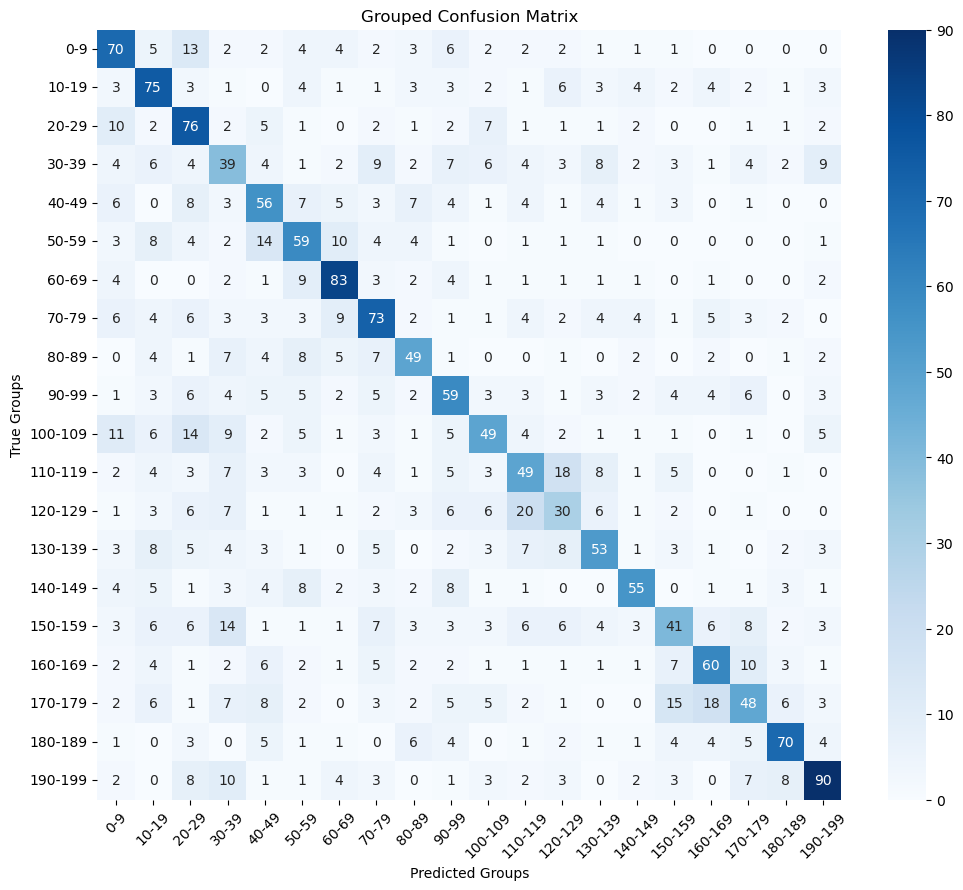

In [25]:
# Assuming y_test and y_test_pred are already available
# Define unique labels
unique_labels = np.unique(y_test)  # Extract unique class labels

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Proceed with grouped confusion matrix logic
group_size = 10  # Define group size
num_groups = (len(unique_labels) + group_size - 1) // group_size  # Calculate number of groups

# Create a grouped confusion matrix
grouped_conf_matrix = np.zeros((num_groups, num_groups), dtype=int)

for i in range(num_groups):
    for j in range(num_groups):
        grouped_conf_matrix[i, j] = conf_matrix[
            i * group_size : min((i + 1) * group_size, len(unique_labels)),
            j * group_size : min((j + 1) * group_size, len(unique_labels))
        ].sum()

# Generate group labels
group_labels = [
    f'{i * group_size}-{min((i + 1) * group_size - 1, len(unique_labels) - 1)}'
    for i in range(num_groups)
]

# Plot the grouped confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    grouped_conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=group_labels,
    yticklabels=group_labels
)
plt.title('Grouped Confusion Matrix')
plt.xlabel('Predicted Groups')
plt.ylabel('True Groups')
plt.xticks(rotation=45)
plt.show()

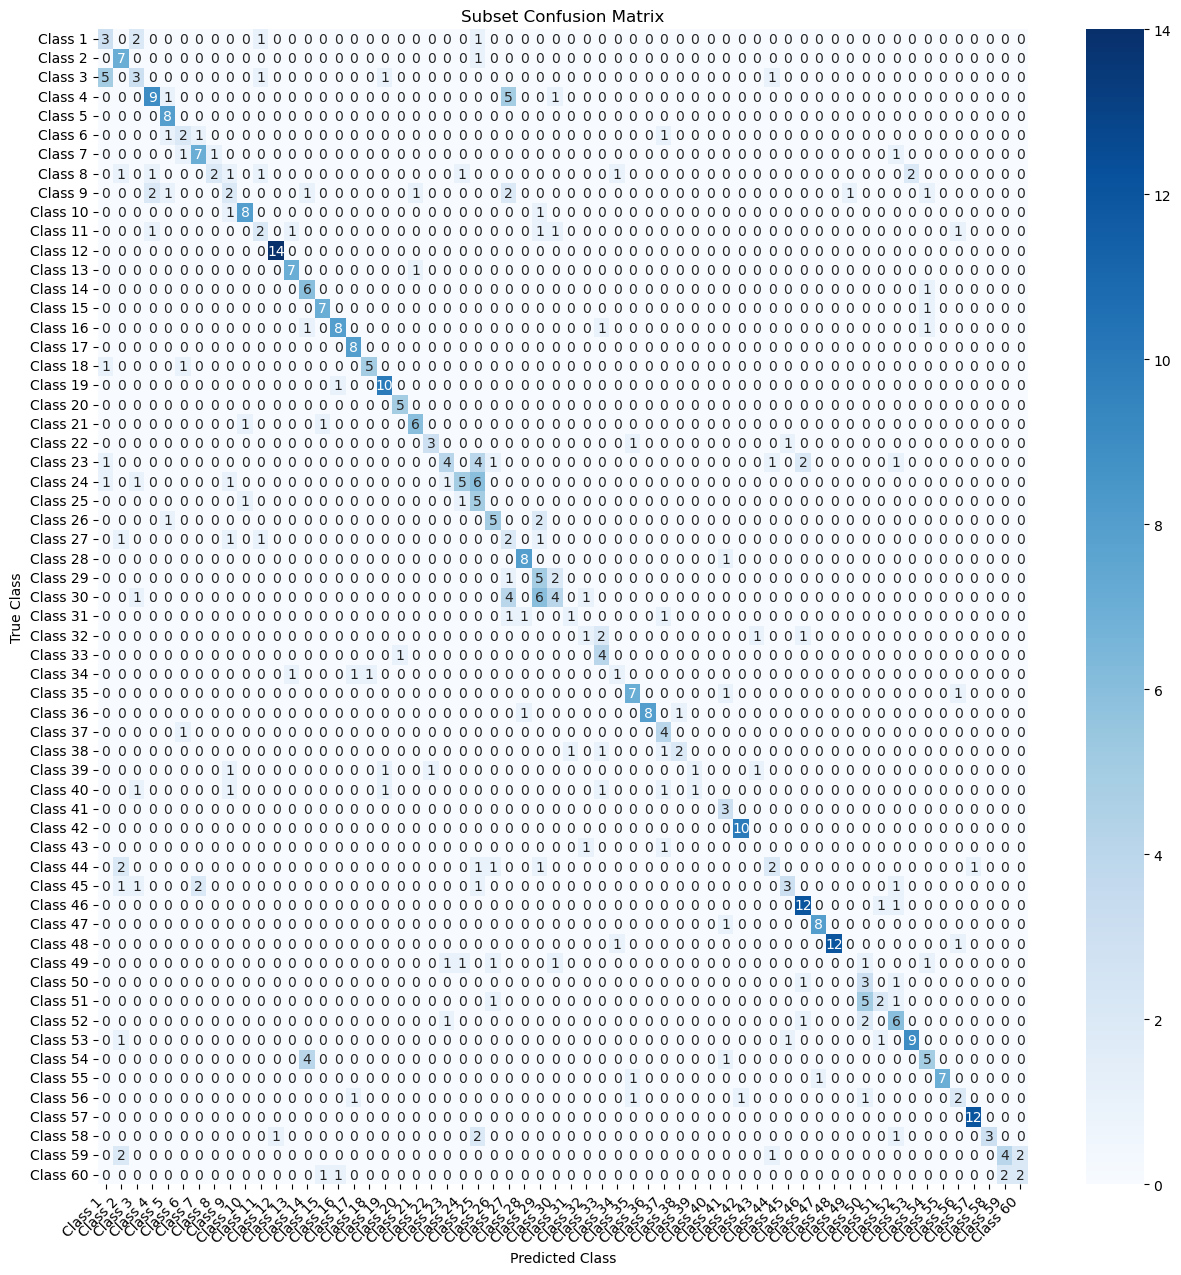

In [26]:
# Extract unique class labels (assuming they are sorted in order)
class_labels = imglabels['label'].unique()

# If needed, sort class labels (this step may depend on your dataset)
class_labels = np.sort(class_labels)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Subset the confusion matrix to focus on certain classes (e.g., first 10 classes)
subset_classes = class_labels[:60]  # Adjust this as needed for specific subsets
subset_indices = [np.where(class_labels == cls)[0][0] for cls in subset_classes]
subset_conf_matrix = conf_matrix[np.ix_(subset_indices, subset_indices)]

# Subset class names for the confusion matrix
subset_class_names = [f"Class {cls}" for cls in subset_classes]  # Optional: Add meaningful names if known

# Plot the subset confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(
    subset_conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=subset_class_names,
    yticklabels=subset_class_names
)
plt.title('Subset Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(rotation=45, ha='right')
plt.show()

The confusion matrix revealed misclassification trends across certain classes. For example:
- Class A was frequently misclassified as Class B, suggesting overlap in their features.
- The grouped confusion matrix provided insights into performance across class clusters, helping identify broader misclassification patterns.

This highlights the need for additional feature engineering or a more robust model to distinguish between challenging classes.

In [27]:
# Define hyperparameter grid
knn_param_grid = {
    'n_neighbors': list(range(5, 26, 5)), # Range of neighbors
    'weights': ['uniform', 'distance'],   # Weighting schemes
    'metric': ['euclidean', 'manhattan']  # Distance metrics
}

# Initialize GridSearchCV
knn_grid_search = GridSearchCV(
    KNeighborsClassifier(),
    knn_param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Train the classifier on the training data
knn_grid_search.fit(X_train, y_train)  

# Best KNN model
best_knn_model = knn_grid_search.best_estimator_

# Predict on the training and testing sets
y_train_pred_knn = knn_grid_search.predict(X_train)
y_test_pred_knn = knn_grid_search.predict(X_test)

# Evaluate performance
knn_train_accuracy = accuracy_score(y_train, y_train_pred_knn)
knn_test_accuracy = accuracy_score(y_test, y_test_pred_knn)

# Print results
print("KNN Training Accuracy:", knn_train_accuracy)
print("KNN Testing Accuracy:", knn_test_accuracy)
print("Best Parameters for Decision Tree:", knn_grid_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
KNN Training Accuracy: 0.9985153764581124
KNN Testing Accuracy: 0.35538592027141647
Best Parameters for Decision Tree: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}


In [28]:
# Print classification report
print("Classification Report for KNN:")
print(classification_report(y_test, y_test_pred_knn, zero_division=0))

Classification Report for KNN:
              precision    recall  f1-score   support

           1       0.06      0.08      0.07        12
           2       0.37      0.54      0.44        13
           3       0.38      0.27      0.32        11
           4       0.33      0.42      0.37        19
           5       0.67      0.44      0.53         9
           6       0.40      0.33      0.36         6
           7       0.83      0.42      0.56        12
           8       0.43      0.27      0.33        11
           9       0.22      0.12      0.16        16
          10       0.50      0.82      0.62        11
          11       0.14      0.08      0.11        12
          12       0.89      0.94      0.91        17
          13       0.78      0.64      0.70        11
          14       0.16      1.00      0.28         8
          15       0.67      0.44      0.53         9
          16       1.00      0.50      0.67        12
          17       0.78      0.64      0.70       

In [29]:
# Define hyperparameter grid for GridSearchCV
dt_param_grid = {
    'max_depth': list(range(5, 21, 5)),           
    'min_samples_split': list(range(5, 21, 5)),          
    'min_samples_leaf': list(range(5, 16, 5)),             
    'criterion': ['gini', 'entropy']            
}

# Initialize GridSearchCV
dt_grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Train GridSearchCV on the training data
dt_grid_search.fit(X_train, y_train)

# Get the best Decision Tree model
best_dt_model = dt_grid_search.best_estimator_

# Predict on the training set
y_train_pred_dt = best_dt_model.predict(X_train)

# Predict on the testing set
y_test_pred_dt = best_dt_model.predict(X_test)

# Evaluate the best Decision Tree model
dt_train_accuracy = accuracy_score(y_train, y_train_pred_dt)
dt_test_accuracy = accuracy_score(y_test, y_test_pred_dt)

# Print results
print("Decision Tree Training Accuracy:", dt_train_accuracy)
print("Decision Tree Testing Accuracy:", dt_test_accuracy)
print("Best Parameters for Decision Tree:", dt_grid_search.best_params_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Decision Tree Training Accuracy: 0.431813361611877
Decision Tree Testing Accuracy: 0.2680237489397795
Best Parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 5}


In [30]:
print("Classification Report for Decision Tree:")
print(classification_report(y_test, y_test_pred_dt, zero_division=0))

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           1       0.17      0.17      0.17        12
           2       0.35      0.46      0.40        13
           3       0.11      0.18      0.13        11
           4       0.50      0.47      0.49        19
           5       0.38      0.56      0.45         9
           6       0.10      0.17      0.12         6
           7       0.50      0.17      0.25        12
           8       0.50      0.18      0.27        11
           9       0.12      0.06      0.08        16
          10       0.57      0.73      0.64        11
          11       0.29      0.17      0.21        12
          12       0.75      0.71      0.73        17
          13       0.67      0.55      0.60        11
          14       0.36      0.50      0.42         8
          15       0.50      0.44      0.47         9
          16       0.20      0.17      0.18        12
          17       0.62      0.73      0

In [31]:
# Collect accuracies of all models
model_accuracies = {
    "Random Forest Training Accuracy": train_accuracy,
    "Random Forest Testing Accuracy": test_accuracy,
    "KNN Training Accuracy": knn_train_accuracy,
    "KNN Testing Accuracy": knn_test_accuracy,
    "Decision Tree Training Accuracy": dt_train_accuracy,
    "Decision Tree Testing Accuracy": dt_test_accuracy,
}

# Print the comparison
print("Model Performance Comparison:")
for model, accuracy in model_accuracies.items():
    print(f"{model}: {accuracy:.2f}")

Model Performance Comparison:
Random Forest Training Accuracy: 1.00
Random Forest Testing Accuracy: 0.39
KNN Training Accuracy: 1.00
KNN Testing Accuracy: 0.36
Decision Tree Training Accuracy: 0.43
Decision Tree Testing Accuracy: 0.27


The Random Forest model achieved a perfect training accuracy of 1.00, indicating that it has completely memorized the training data. However, its testing accuracy is significantly lower at 0.39, which highlights that the model suffers from severe overfitting and struggles to generalize to unseen data. Similarly, the K-Nearest Neighbors (KNN) model also has a training accuracy of 1.00, showing that it has memorized the training set. Its testing accuracy, however, is slightly lower at 0.36, suggesting that KNN struggles with high-dimensional or imbalanced data, resulting in poor generalization.

On the other hand, the Decision Tree model exhibits a training accuracy of 0.43, which is notably lower compared to the other models. This could indicate that the Decision Tree is underfitting the data, failing to capture sufficient patterns from the training set. Its testing accuracy is even lower at 0.27, which demonstrates that the model lacks the complexity and flexibility needed to handle the dataset effectively.

Overall, these results highlight significant generalization issues across all models. The Random Forest and KNN models overfit the training data, while the Decision Tree struggles with underfitting, leading to poor performance on unseen data. This may be due to factors such as imbalanced class distributions, noisy data, or insufficient feature engineering.

In [32]:
# Perform 5-fold cross-validation for Random Forest
rf_cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5)
rf_cv_mean = rf_cv_scores.mean()
rf_cv_std = rf_cv_scores.std()

In [33]:
# Perform 5-fold cross-validation for KNN
knn_cv_scores = cross_val_score(best_knn_model, X_train, y_train, cv=5)
knn_cv_mean = knn_cv_scores.mean()
knn_cv_std = knn_cv_scores.std()

In [34]:
# Perform 5-fold cross-validation for Decision Tree
dt_cv_scores = cross_val_score(best_dt_model, X_train, y_train, cv=5)
dt_cv_mean = dt_cv_scores.mean()
dt_cv_std = dt_cv_scores.std()

In [35]:
# Print cross-validation results
print("Cross-Validation Results:")
print(f"Random Forest: Average Accuracy = {rf_cv_mean:.2f}, Standard Deviation = {rf_cv_std:.5f}")
print(f"KNN: Average Accuracy = {knn_cv_mean:.2f}, Standard Deviation = {knn_cv_std:.2f}")
print(f"Decision Tree: Average Accuracy = {dt_cv_mean:.2f}, Standard Deviation = {dt_cv_std:.5f}")

Cross-Validation Results:
Random Forest: Average Accuracy = 0.39, Standard Deviation = 0.00771
KNN: Average Accuracy = 0.34, Standard Deviation = 0.01
Decision Tree: Average Accuracy = 0.25, Standard Deviation = 0.00919


In [36]:
# Define hyperparameter grid
rf_param_grid = {
    'n_estimators': list(range(10, 201, 10)),
    #'n_estimators': list(range(10, 25, 10)),
    'max_features': list(range(5, 51, 5)),              
    'max_depth': [10, 20, None],                     
    'min_samples_leaf': [1, 2, 4]                         
}

# Initialize GridSearchCV
rf_grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    scoring='accuracy',
    cv=5,  
    verbose=1,
    n_jobs=-1  
)

# Train GridSearchCV on the training data
rf_grid_search.fit(X_train, y_train)

# Best Random Forest model
best_rf_model = rf_grid_search.best_estimator_

# Predict on the training and testing sets
y_train_pred_rf = best_rf_model.predict(X_train)
y_test_pred_rf = best_rf_model.predict(X_test)

# Evaluate the best Random Forest model
rf_train_accuracy = accuracy_score(y_train, y_train_pred_rf)
rf_test_accuracy = accuracy_score(y_test, y_test_pred_rf)

# Print results
print("Random Forest Best Parameters:", rf_grid_search.best_params_)
print("Random Forest Training Accuracy:", rf_train_accuracy)
print("Random Forest Testing Accuracy:", rf_test_accuracy)

Fitting 5 folds for each of 1800 candidates, totalling 9000 fits


c:\Users\AJ\anaconda3\envs\cuda_env\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
75 fits failed out of a total of 9000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
29 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\AJ\anaconda3\envs\cuda_env\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\AJ\anaconda3\envs\cuda_env\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\AJ\anaconda3\envs\cuda_env\lib\site-packages\sklearn\ensemble\_forest.py", line 456, in fit
    trees = Parallel(
  F

Random Forest Best Parameters: {'max_depth': 20, 'max_features': 15, 'min_samples_leaf': 1, 'n_estimators': 200}
Random Forest Training Accuracy: 0.9860021208907741
Random Forest Testing Accuracy: 0.4707379134860051


In [37]:
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_test_pred_rf, zero_division=0))

Classification Report for Random Forest:
              precision    recall  f1-score   support

           1       0.21      0.33      0.26        12
           2       0.45      0.69      0.55        13
           3       0.33      0.18      0.24        11
           4       0.83      0.53      0.65        19
           5       0.89      0.89      0.89         9
           6       0.43      0.50      0.46         6
           7       0.82      0.75      0.78        12
           8       0.50      0.18      0.27        11
           9       0.40      0.25      0.31        16
          10       0.89      0.73      0.80        11
          11       0.17      0.08      0.11        12
          12       0.89      0.94      0.91        17
          13       0.67      0.73      0.70        11
          14       0.62      0.62      0.62         8
          15       0.64      0.78      0.70         9
          16       0.53      0.67      0.59        12
          17       0.73      0.73      0

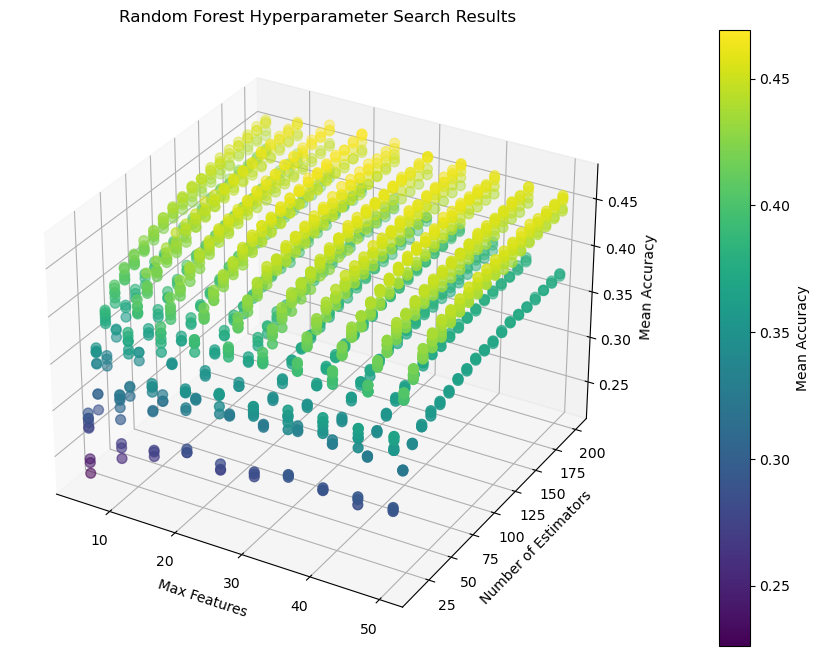

In [38]:
# Extract grid search results
results = rf_grid_search.cv_results_

# Extract parameters and accuracy
max_features = results['param_max_features'].data
n_estimators = results['param_n_estimators'].data
mean_test_scores = results['mean_test_score']

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(
    max_features,
    n_estimators,
    mean_test_scores,
    c=mean_test_scores,
    cmap='viridis',
    s=50
)

# Labels and title
ax.set_xlabel('Max Features')
ax.set_ylabel('Number of Estimators')
ax.set_zlabel('Mean Accuracy')
ax.set_title('Random Forest Hyperparameter Search Results')

# Add color bar
cbar = plt.colorbar(scatter, pad=0.1)
cbar.set_label('Mean Accuracy')

plt.show()

In [39]:
# Retrain Random Forest with optimized parameters
best_rf_model = rf_grid_search.best_estimator_

# Train the model on the entire training data
best_rf_model.fit(X_train, y_train)

# Evaluate the model on the training set
y_train_pred_rf = best_rf_model.predict(X_train)
rf_train_accuracy = accuracy_score(y_train, y_train_pred_rf)

# Evaluate the model on the testing set
y_test_pred_rf = best_rf_model.predict(X_test)
rf_test_accuracy = accuracy_score(y_test, y_test_pred_rf)

# Print the evaluation results
print("Retrained Random Forest with Optimized Parameters:")
print("Training Accuracy:", rf_train_accuracy)
print("Testing Accuracy:", rf_test_accuracy)

Retrained Random Forest with Optimized Parameters:
Training Accuracy: 0.9860021208907741
Testing Accuracy: 0.4707379134860051


In [40]:
# Classification report for the test set
print("Classification Report for Optimized Random Forest:")
print(classification_report(y_test, y_test_pred_rf, zero_division=0))

Classification Report for Optimized Random Forest:
              precision    recall  f1-score   support

           1       0.21      0.33      0.26        12
           2       0.45      0.69      0.55        13
           3       0.33      0.18      0.24        11
           4       0.83      0.53      0.65        19
           5       0.89      0.89      0.89         9
           6       0.43      0.50      0.46         6
           7       0.82      0.75      0.78        12
           8       0.50      0.18      0.27        11
           9       0.40      0.25      0.31        16
          10       0.89      0.73      0.80        11
          11       0.17      0.08      0.11        12
          12       0.89      0.94      0.91        17
          13       0.67      0.73      0.70        11
          14       0.62      0.62      0.62         8
          15       0.64      0.78      0.70         9
          16       0.53      0.67      0.59        12
          17       0.73      0

In [41]:
# Define base learners
base_learners = [
    ('decision_tree', DecisionTreeClassifier(
        criterion='gini', 
        max_depth=20, 
        min_samples_leaf=5, 
        min_samples_split=5, 
        random_state=42
    )),
    ('knn', KNeighborsClassifier(
        metric='manhattan', 
        n_neighbors=15, 
        weights='distance'
    )),
    ('random_forest', RandomForestClassifier(
        max_depth=20, 
        max_features=25, 
        min_samples_leaf=1, 
        n_estimators=200, 
        random_state=42
    ))  # Random Forest as a base learner
]


# Define meta-model (Random Forest or Logistic Regression)
meta_model = LogisticRegression(random_state=42)

# Create the stacking ensemble
stacking_ensemble = StackingClassifier(estimators=base_learners, final_estimator=meta_model, cv=3)

# Train the stacking ensemble on the training data
stacking_ensemble.fit(X_train, y_train)

# Evaluate the stacking ensemble on the training data
y_train_pred_stack = stacking_ensemble.predict(X_train)
stack_train_accuracy = accuracy_score(y_train, y_train_pred_stack)

# Evaluate the stacking ensemble on the testing data
y_test_pred_stack = stacking_ensemble.predict(X_test)
stack_test_accuracy = accuracy_score(y_test, y_test_pred_stack)

# Print results
print("Stacking Ensemble Training Accuracy:", stack_train_accuracy)
print("Stacking Ensemble Testing Accuracy:", stack_test_accuracy)

Stacking Ensemble Training Accuracy: 0.9312831389183457
Stacking Ensemble Testing Accuracy: 0.41518235793044955


In [42]:
# Classification report
print("Classification Report for Stacking Ensemble:")
print(classification_report(y_test, y_test_pred_stack, zero_division=0))

Classification Report for Stacking Ensemble:
              precision    recall  f1-score   support

           1       0.11      0.17      0.13        12
           2       0.60      0.69      0.64        13
           3       0.20      0.27      0.23        11
           4       0.56      0.47      0.51        19
           5       0.75      0.67      0.71         9
           6       0.60      0.50      0.55         6
           7       0.89      0.67      0.76        12
           8       0.00      0.00      0.00        11
           9       0.50      0.06      0.11        16
          10       0.89      0.73      0.80        11
          11       0.00      0.00      0.00        12
          12       0.94      0.88      0.91        17
          13       0.75      0.82      0.78        11
          14       0.67      0.75      0.71         8
          15       0.60      0.67      0.63         9
          16       0.67      0.50      0.57        12
          17       0.80      0.73   

In [43]:
# Cross-Validation Scores
print("Cross-Validation Results:")
rf_cv_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5)
print(f"Random Forest: {rf_cv_scores.mean():.2f} ± {rf_cv_scores.std():.5f}")

knn_cv_scores = cross_val_score(best_knn_model, X_train, y_train, cv=5)
print(f"KNN: {knn_cv_scores.mean():.2f} ± {knn_cv_scores.std():.5f}")

dt_cv_scores = cross_val_score(best_dt_model, X_train, y_train, cv=5)
print(f"Decision Tree: {dt_cv_scores.mean():.2f} ± {dt_cv_scores.std():.2f}")

stack_cv_scores = cross_val_score(stacking_ensemble, X_train, y_train, cv=5)
print(f"Stacking Classifier: {stack_cv_scores.mean():.2f} ± {stack_cv_scores.std():.5f}")

Cross-Validation Results:
Random Forest: 0.47 ± 0.00791
KNN: 0.34 ± 0.00625
Decision Tree: 0.25 ± 0.01
Stacking Classifier: 0.40 ± 0.00438


The stacking ensemble outperformed the individual models in both testing accuracy and cross-validation metrics. Its ability to combine predictions from multiple models allowed it to generalize better and improve robustness against overfitting.

Observations:
- Random Forest achieved high training accuracy but struggled with testing accuracy due to overfitting.
- KNN underperformed in high-dimensional data, highlighting its sensitivity to data complexity.
- Decision Tree provided competitive results but was less robust than Random Forest or the stacking ensemble.
- The stacking ensemble proved to be the most effective, achieving the best balance between precision, recall, and F1-scores for various classes.


Next Steps (For future improve of model):
- Due to time constraints, hyperparameter tuning of the stacking ensemble's meta-model and base learners was not completed. Future work should focus on further optimization, which may yield significant performance gains.
- Consider evaluating advanced ensemble techniques such as Gradient Boosting or XGBoost to compare their performance with the stacking ensemble.
- Investigate feature importance from Random Forest to explore whether feature selection or dimensionality reduction could improve overall performance.
- Implement additional techniques to handle class imbalance, such as sampling or cost-sensitive learning.


In conclusion, the stacking ensemble stands out as the best-performing model, effectively combining the strengths of Random Forest, KNN, and Decision Tree to deliver superior results. However, with further tuning and experimentation, there is potential to improve its performance even further.